# Imports and processes firn cores from SUMUP (2024) dataset and a standardized dataset compiled by Peter Kuipers Munneke

In [59]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import xarray as xr

from scipy.optimize import curve_fit
from scipy.optimize import fsolve, brentq

from merge_datasets import *
from process_standardized_cores import *
from process_sumup_cores import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Processing SUMup data

First, load all the data from the region of interest (Antarctica or Greenland). Set the paths appropriately so that it links to your own folder with sumup data.

In [ ]:
# process sumup cores

data_path = "/home/nld4814/perm/cores/sumup/data/raw/"  # Update this to your SUMup data folder
output_path = "/home/nld4814/perm/cores/sumup/data/processed/"  # Path to save output files (can be same as data_path)
output_prefix = "sumup_550_830_density_depths"  # Will create _greenland.csv, _antarctica.csv, and _combined.csv files
domain = "greenland"

density_df, profile_names_df, references_df = load_sumup_data(data_path, domain)


Loading SUMup data files...
Loading Greenland data only
Loaded 1,976,302 greenland density measurements
Loaded 4229 profile names
Loaded 271 references


We can select cores from the density dataset `density_df` by profile_key -- this gives us all the measurements of depth and density; the other information is identical. We can then plot it, and use the core's name for it's title by searching for the `profile_key` in the `profile_names_df` dataframe.

Text(0.5, 0, 'Density [kg/m3]')

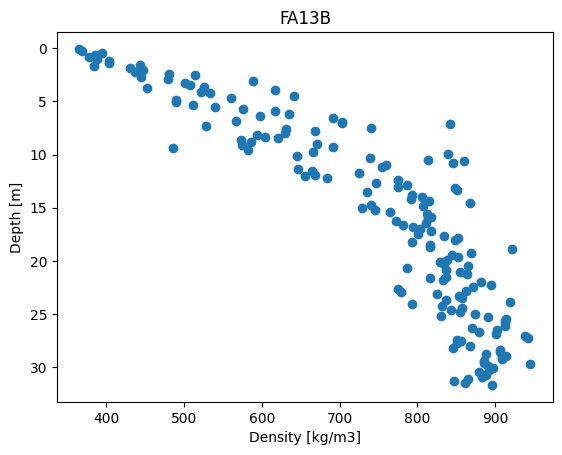

In [22]:
prof57 = density_df[density_df["profile_key"]==57]
plt.plot(prof57["density"],prof57["midpoint"], 'o')
plt.title(profile_names_df.loc[57]["profile"])
plt.gca().invert_yaxis()
plt.ylabel("Depth [m]")
plt.xlabel("Density [kg/m3]")

There are a few ways of going about choosing depth to 550 kg/m3 and 830 kg/m3. We are going to take the easiest option: look for the first instance where the depth exceeds the target density, and we interpolate between that point and the point previous to get the depth. We could also fit a curve to the depth-density profile, and then select a depth from there. We cannot just use a built in funciton like `interp_1d` because the densities often do not monotonically increase with depth

In [42]:
# let's simplify the structure of our dataframe so we can find the depths of the target densities more easily

prof57 = density_df[density_df["profile_key"]==57]
prof57 = prof57.drop(columns=['reference_key', 'method_key', 'start_depth', 'stop_depth', 'error', 'region'])
prof57 = prof57.rename(columns={"midpoint": "depth"})
prof57.head()

,profile_key,timestamp,latitude,longitude,elevation,depth,density
0,57,2013-04-08,66.1812,-39.043499,1563.0,0.220,368.42
1,57,2013-04-08,66.1812,-39.043499,1563.0,1.175,402.91
2,57,2013-04-08,66.1812,-39.043499,1563.0,14.710,740.07
3,57,2013-04-08,66.1812,-39.043499,1563.0,0.425,394.59
4,57,2013-04-08,66.1812,-39.043499,1563.0,0.630,385.00


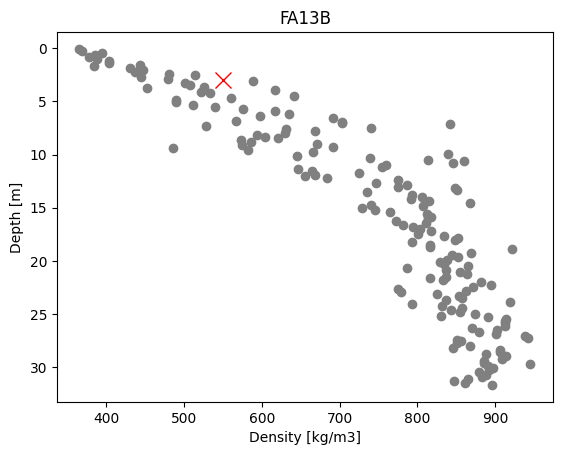

In [45]:
# an example for a target density of 550
df = prof57.copy()
failed = False

target_density = 550

depth = np.array(df.depth.values)
density = np.array(df.density.values)

# Sort by depth - should monotonically increase (but density likely won't)
sort_idx = np.argsort(depth)
depth_sorted = depth[sort_idx]
density_sorted = density[sort_idx]

# Check if target density is reached
if np.max(density_sorted) < target_density:
    print("Core too shallow, do not proceed")
    failed = True
    #return np.nan

if not failed:
    # Find first point where target density is reached or exceeded
    idx = np.where(density_sorted >= target_density)[0]

    first_idx = idx[0]
    
    # If first measurement already exceeds target, interpolate previous depth is zero. we choose 350 to be the density at the surface.
    if first_idx == 0:
        prev_depth = 0
        prev_density = 350
    else:
        prev_depth = depth_sorted[first_idx - 1]
        prev_density = density_sorted[first_idx - 1]
    
    curr_depth = depth_sorted[first_idx]
    curr_density = density_sorted[first_idx]
        
    # Weighted interpolatation based on distance and density difference
    interpolated_depth = prev_depth + (target_density - prev_density) * (curr_depth - prev_depth) / (curr_density - prev_density)

    interpolated_depth = round(interpolated_depth,2)

    #now let's plot it and make sure it looks reasonable

    plt.plot(df["density"],df["depth"], 'o', color="grey")
    plt.plot(550, interpolated_depth, 'rx', markersize=12, label='Interpolated Depth at 550 kg/m3')
    plt.gca().invert_yaxis()
    plt.ylabel("Depth [m]")
    plt.xlabel("Density [kg/m3]")

    plt.title(profile_names_df.loc[57]["profile"])



We could also choose to fit a curve to the data and then select a density from there. In general, a logarithmic or power law fit does well with depth-density datasets.

First we define the fits we could use, and the minimization of that fit with a target (for finding the depth at target density later on)

In [48]:
def power_law(x, a, b, c):
    return a * x**b + c

def power_law_minimization(x, a, b, c, target):
    return a * x**b + c - target

def logarithmic(x, a, b, c):
    return a * np.log(x + 1) + b * x + c

def log_minimization(x, a, b, c, target):
    return a * np.log(x + 1) + b * x + c - target

models = [
    (power_law, "Power law", "a*x^b + c", 'blue'),
    (logarithmic, "Logarithmic", "a*log(x+1) + b*x + c", 'green')
]

Then we fit the models to the data. Let's start with the logarithmic curve

In [ ]:
model = models[1]
func = model[0]
color = model[3]

fitted_params = {}

depth_smooth = np.linspace(depth.min(), depth.max(), 200)

popt, pcov = curve_fit(func, depth, density)

# Store parameters with a simple key
model_name = "logarithmic"
fitted_params[model_name] = popt

# Calculate fitted values
density_smooth = func(depth_smooth, *popt)


Now we can find the density at the target depth using the fit we just calculated

In [53]:
try:
    depth_at_rho = brentq(
        log_minimization,
        depth.min(),
        depth.max(),
        args=(*popt, target_density)
    )
    #print(f"Using brentq (Logarithmic): {depth_at_rho:.2f}")
except ValueError as e:
    #print(f"brentq failed for logarithmic: {e}")
    #print("Target density might be outside the range of your data")
    depth_at_rho = np.nan
    failed = int(1)



And plot them

Text(0.5, 1.0, 'FA13B')

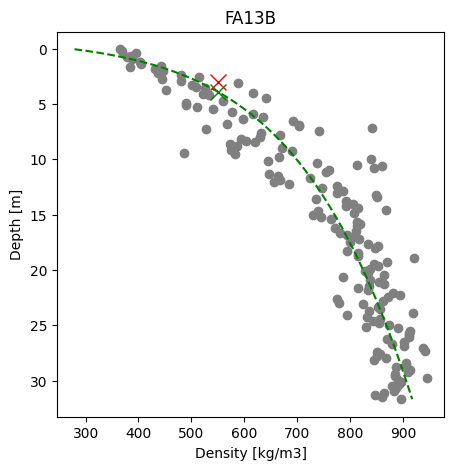

In [56]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(density, depth, 'o', color='grey', label='Core Observations')
ax.plot(density_smooth, depth_smooth, '--', color=color, label=f'Fitted {model[1]}')
ax.plot(target_density, depth_at_rho, 'gx', markersize=12, label='Model fit')
plt.plot(550, interpolated_depth, 'rx', markersize=12, label='Point interpolation')
plt.gca().invert_yaxis()
plt.ylabel("Depth [m]")
plt.xlabel("Density [kg/m3]")

plt.title(profile_names_df.loc[57]["profile"])


In [68]:
#In processing the SUMup dataset, we choose to try to do a logarithmic fit; if that fit fails or if the r2 of that fit is <0.9, then we do the first index approach.

process_sumup_main()

Loading SUMup data files...
Loading Greenland data only
Loaded 1,976,302 greenland density measurements
Loaded 4229 profile names
Loaded 271 references
Processing individual cores...
  - Model fit failed for target density 550 kg/m³
  - Using direct interpolation method instead.
Error: Axes.set() got an unexpected keyword argument 'figsize'

Make sure you have downloaded the SUMup data files.

    To use this script, you need to download the SUMup 2023 dataset:
    
    1. Go to: https://arcticdata.io/catalog/view/doi:10.18739/A2M61BR5M
    2. Download the following CSV files:
       - SUMup_2024_density_csv.zip
            - SUMup_2024_density_greenland.csv
            - SUMup_2024_density_antarctica.csv
            - SUMup_2024_density_profile_names.tsv
            - SUMup_2024_density_references.tsv
    
    3. Place them in a folder and update the 'data_path' variable below.
    


<Figure size 800x700 with 0 Axes>

In [61]:
# check sumup processed
sumup_df = pd.read_csv("/home/nld4814/perm/cores/sumup/data/processed/sumup_550_830_density_depths_greenland.csv")

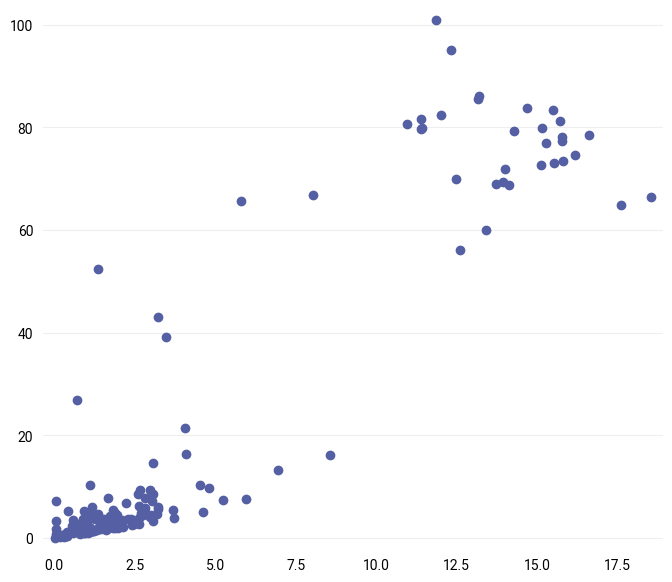

In [65]:
plt.plot(sumup_df["depth_to_550"], sumup_df["depth_to_830"],'o')

In [ ]:
merged_df=merge_datasets(do_run_sumup_processing=False, do_run_std_processing=False, drop_duplicates=True)


Loading SUMUP dataset from /home/nld4814/perm/cores/sumup/data/processed/sumup_550_830_density_depths_greenland.csv
Loaded 433 SUMUP records
SUMUP columns: ['core_name', 'profile_key', 'date', 'region', 'latitude', 'longitude', 'elevation', 'citation', 'n_measurements', 'max_depth', 'max_density', 'depth_to_550', 'depth_to_830', 'year', 'source', 'source_doi']

Loading standardized dataset from /home/nld4814/perm/cores/PKM/processed/PKM_550_830_density_depths_greenland.csv
Loaded 62 standardized records
Standardized columns: ['core_name', 'latitude', 'longitude', 'elevation', 'year', 'depth_to_550', 'depth_to_830', 'source', 'method', 'citation', 'measurement_count', 'source_file', 'region']

Identifying duplicates...
Found 29 potential duplicate pairs

Creating final dataset...
Removed 5 cores missing depth_to_550
Final dataset contains 464 cores

=== MERGING COMPLETE ===
Final merged dataset saved to: /home/nld4814/perm/cores/MERGED_CORE_LIST_greenland_2025.csv
Cores with 550 kg/m³ 

/etc/ecmwf/nfs/dh1_perm_b/nld4814/code/process-cores/merge_datasets.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  location_matches = location_matches[
/etc/ecmwf/nfs/dh1_perm_b/nld4814/code/process-cores/merge_datasets.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  location_matches = location_matches[
/etc/ecmwf/nfs/dh1_perm_b/nld4814/code/process-cores/merge_datasets.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  location_matches = location_matches[
/etc/ecmwf/nfs/dh1_perm_b/nld4814/code/process-cores/merge_datasets.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  location_matches = location_matches[
/etc/ecmwf/nfs/dh1_perm_b/nld4814/code/process-cores/merge_datasets.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  location_matches = location_matches[
/etc/ecmwf/nfs/dh1_perm_b/nld4814/code/process-cor

In [4]:
merged_df

,core_name,latitude,longitude,elevation,year,depth_to_550,depth_to_830,source,citation,region
0,Wegener_RA145_1930-07-21,71.192,-46.989,2155.0,1930,0.940,NaN,SUMUP 2024,Jülg (1939) as in Abermann et al. (2023),Greenland
1,Wegener_RA170_1930-07-22,71.191,-46.281,2255.0,1930,0.704,NaN,SUMUP 2024,Jülg (1939) as in Abermann et al. (2023),Greenland
2,Eismitte_1931-01-22,71.183,-39.933,3010.0,1931,8.273,NaN,SUMUP 2024,Sorge et al. (1935) as in Abermann et al. (2023),Greenland
3,Eismitte_1931-03-04,71.183,-39.933,3010.0,1931,12.921,NaN,SUMUP 2024,Sorge et al. (1935) as in Abermann et al. (2023),Greenland
4,Eismitte_1931-04-23,71.183,-39.933,3010.0,1931,14.023,NaN,SUMUP 2024,Sorge et al. (1935) as in Abermann et al. (2023),Greenland
...,...,...,...,...,...,...,...,...,...,...
459,GC-Net_KAN_U_snowpit,67.001,-47.035,1840.0,2024,0.674,NaN,SUMUP 2024,GEUS snow and firn data (2023),Greenland
460,GC-Net_NEM_core,77.441,-51.084,2454.0,2024,9.499,NaN,SUMUP 2024,GEUS snow and firn data (2023),Greenland
461,GC-Net_NSE_S1_core,66.478,-42.493,NaN,2024,7.797,NaN,SUMUP 2024,GEUS snow and firn data (2023),Greenland
462,GC-Net_SDL_S1_core,66.000,-44.502,NaN,2024,12.371,NaN,SUMUP 2024,GEUS snow and firn data (2023),Greenland


<Axes: title={'center': 'Depth to 830 kg/m³ '}, xlabel='Longitude', ylabel='Latitude'>

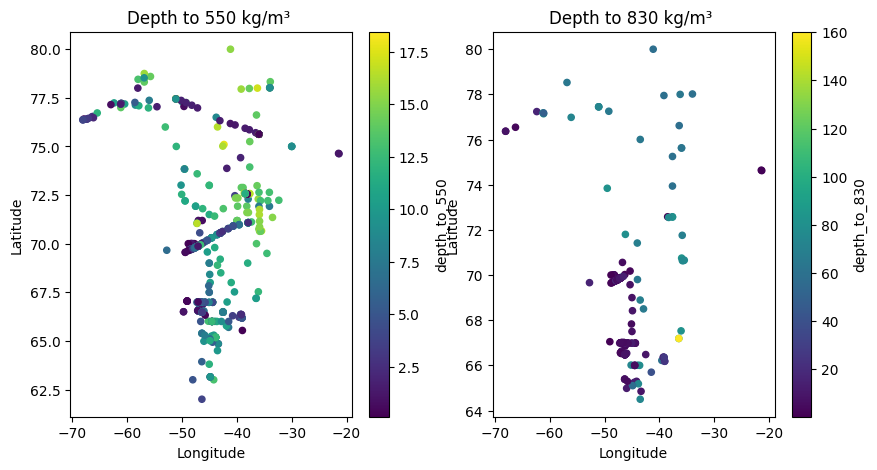

In [5]:
# plot cores

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10, 5))
merged_df.plot.scatter(x='longitude', y='latitude', c='depth_to_550', title='Depth to 550 kg/m³ ', xlabel='Longitude', ylabel='Latitude', ax=ax[0])
merged_df.plot.scatter(x='longitude', y='latitude', c='depth_to_830', title='Depth to 830 kg/m³ ', xlabel='Longitude', ylabel='Latitude', ax=ax[1])



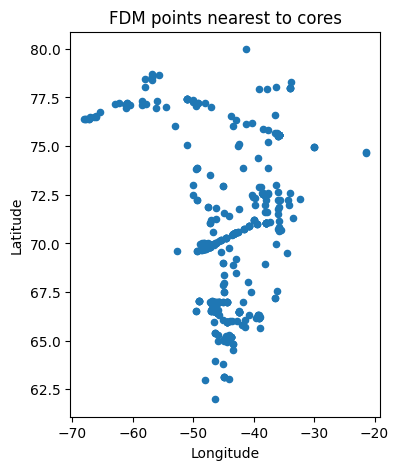

In [ ]:
# extracts FDM points nearest to cores

save_pointlist = False

# import fdm reference list
path_to_fdm_locations = "/perm/nld4814/code/IMAU-FDM/reference/FGRN055/"
pointlist_df = pd.read_csv(path_to_fdm_locations+'IN_ll_FGRN055.txt',names=["longitude","latitude"],usecols=[0,1])

core_locations = merged_df[['latitude','longitude']].to_numpy()

df = pointlist_df

xs = []; distances = []  # distance between the pair of points
for point in core_locations:

    assert len(point) == 2, "``points`` should be a tuple or list of tuples (lat, lon)"

    p_lat, p_lon = point
    # Find absolute difference between requested point and the grid coordinates.
    abslat = np.abs(df.latitude - p_lat)
    abslon = np.abs(df.longitude - p_lon)

    # Create grid of the maximum values of the two absolute grids
    c = np.maximum(abslon, abslat)

    # Find location where lat/lon minimum absolute value intersects
    x = np.where(c == np.min(c))[0][0]
    xs.append(x)

    # Matched Grid lat/lon
    g_lat = df.iloc[x,:].latitude
    g_lon = df.iloc[x,:].longitude

    R = 6373.0  # approximate radius of earth in km

    lat1 = np.deg2rad(p_lat); lon1 = np.deg2rad(p_lon)
    lat2 = np.deg2rad(g_lat); lon2 = np.deg2rad(g_lon)
    dlon = lon2 - lon1; dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    distances.append(distance)

pointlist_df.loc[xs].plot.scatter(x='longitude', y='latitude', title='FDM points nearest to cores', xlabel='Longitude', ylabel='Latitude',figsize=(4,5))

if save_pointlist:
    output_path = "/home/nld4814/perm/cores/pointlist_from_cores_2025.csv"
    pointlist_near_cores = pointlist_df.loc[xs].index.values
    np.savetxt(output_path, pointlist_near_cores, fmt='%d')